In [2]:
using Plots, LinearAlgebra, LaTeXStrings, Printf
gr()

Plots.GRBackend()

In [ ]:
rosenbrock(x) = (1 - x[1])^2 + 100(x[2] - x[1]^2)^2
rastrigin(x) = 20 + sum(xi^2 - 10cos(2π * xi) for xi in x)
schwefel(x) = 418.9829 * length(x) - sum(xi * sin(sqrt(abs(xi))) for xi in x)

const FUNCTIONS = Dict(
    "Rosenbrock" => (f=rosenbrock, x0=[-1.5, -1.0], xr=(-2.0, 2.0), yr=(-1.5, 3.0), clim=(0, 500), xopt=[1.0, 1.0]),
    "Rastrigin" => (f=rastrigin, x0=[-4.0, 3.0], xr=(-5.12, 5.12), yr=(-5.12, 5.12), clim=(0, 80), xopt=[0.0, 0.0]),
    "Schwefel" => (f=schwefel, x0=[-200.0, 300.0], xr=(-500.0, 500.0), yr=(-500.0, 500.0), clim=(0, 1800), xopt=[420.9687, 420.9687]),
)

struct ProbePoint # для графика true = функция убыла - синяя
    x::Vector{Float64}
    improved::Bool
end

function exploratory_search(f, x, Delta)
    n = length(x)
    x_new = copy(x)
    fx = f(x_new)
    probes = ProbePoint[]
    for i in 1:n
        x_trial = copy(x_new)
        x_trial[i] += Delta[i]
        ft = f(x_trial)
        push!(probes, ProbePoint(copy(x_trial), ft < fx))
        if ft < fx
            x_new = x_trial
            fx = ft
        else
            x_trial = copy(x_new)
            x_trial[i] -= Delta[i]
            ft = f(x_trial)
            push!(probes, ProbePoint(copy(x_trial), ft < fx))
            if ft < fx
                x_new = x_trial
                fx = ft
            end
        end
    end
    return x_new, probes
end

function hooke_jeeves(f, x0, Delta0; eps=1e-6, max_iter=5000, pattern_mode=:single)
    x_base = copy(Float64.(x0))
    Delta = copy(Float64.(Delta0))
    path = [copy(x_base)]
    all_probes = Vector{ProbePoint}[]
    iter = 0
    while maximum(abs.(Delta)) > eps && iter < max_iter
        iter += 1
        x1, probes = exploratory_search(f, x_base, Delta)
        push!(all_probes, probes)
        if f(x1) >= f(x_base)
            Delta ./= 2.0
            continue
        end
        push!(path, copy(x1))
        if pattern_mode == :single
            x_pattern = 2x1 - x_base
            x2, probes2 = exploratory_search(f, x_pattern, Delta)
            push!(all_probes, probes2)
            if f(x2) < f(x1)
                x_base = x2
            else
                x_base = x1
            end
            push!(path, copy(x_base))
        elseif pattern_mode == :multi
            x_prev = x_base
            x_curr = x1
            while true
                x_pattern = 2*x_curr - x_prev
                x_next, probes_p = exploratory_search(f, x_pattern, Delta)
                push!(all_probes, probes_p)
                if f(x_next) < f(x_curr)
                    push!(path, copy(x_next))
                    x_prev = x_curr
                    x_curr = x_next
                else
                    break
                end
            end
            x_base = x_curr
        end
    end
    return path, all_probes, iter
end

function make_grid(info; N=200)
    xs = range(info.xr..., length=N)
    ys = range(info.yr..., length=N)
    Z = [info.f([x, y]) for y in ys, x in xs]
    return xs, ys, Z
end

function visualize(fname, info, path, probes, iter, label)
    xs, ys, Z = make_grid(info)
    Z_clip = clamp.(Z, info.clim...)
    px = [p[1] for p in path]
    py = [p[2] for p in path]
    pz = [info.f(p) for p in path]
    p3d = surface(xs, ys, Z_clip, xlabel="x_1", ylabel="x_2", zlabel="f(x)",
        title="$fname — $label\niter=$iter  path=$(length(path))  f*=$(@sprintf("%.4f", pz[end]))",
        alpha=0.6, colorbar=false, camera=(30, 50), size=(700, 550))
    plot!(p3d, px, py, pz, lw=2, color=:green, marker=:circle, ms=3,
        markerstrokewidth=0, markercolor=:lime, label="path")
    pcnt = contour(xs, ys, Z_clip, levels=35, fill=true, xlabel="x_1", ylabel="x_2",
        title="$fname — $label\niter=$iter  path=$(length(path))", size=(700, 550), color=:viridis, clim=info.clim)
    plot!(pcnt, px, py, lw=2, color=:green, marker=:circle, ms=3, markerstrokewidth=0, markercolor=:lime, label="path")
    for step_probes in probes
        for pp in step_probes
            c = pp.improved ? :blue : :red
            scatter!(pcnt, [pp.x[1]], [pp.x[2]],
                ms=2, markerstrokewidth=0, markercolor=c, label=false)
        end
    end
    scatter!(pcnt, [info.xopt[1]], [info.xopt[2]], marker=:star5, ms=8, markercolor=:gold, label="optimum")
    scatter!(pcnt, [px[1]], [py[1]], marker=:diamond, ms=6, markercolor=:white, markerstrokecolor=:black, 
        markerstrokewidth=1, label="start")
    return p3d, pcnt
end

function run_all()
    all_plots = []
    println("="^80)
    println("  СРАВНЕНИЕ: поиск по образцу (1 раз) vs (многократно с проверкой убывания)")
    println("="^80)
    @printf("%-12s %-22s %6s %8s %12s %s\n","Функция", "Режим", "Iter", "PathLen", "f(x*)", "x*")
    println("-"^80)
    for fname in ["Rosenbrock", "Rastrigin", "Schwefel"]
        info = FUNCTIONS[fname]
        Delta0 = fname == "Schwefel" ? [50.0, 50.0] : [0.5, 0.5]
        for (mode, label) in [(:single, "образец 1 раз"), (:multi, "образец многократно")]
            path, probes, iter = hooke_jeeves(info.f, info.x0, Delta0; pattern_mode=mode, max_iter=10000)
            fval = info.f(path[end])
            @printf("%-12s %-22s %6d %8d %12.6f [%.4f, %.4f]\n",
                fname, label, iter, length(path), fval, path[end][1], path[end][2])
            p3d, pcnt = visualize(fname, info, path, probes, iter, label)
            push!(all_plots, (fname, label, p3d, pcnt))
        end
    end
    println("="^80)
    mkpath("plots")
    for (fname, label, p3d, pcnt) in all_plots
        safe = replace("$(fname)_$(label)", " " => "_")
        savefig(p3d, "plots/$(safe)_3d.png")
        savefig(pcnt, "plots/$(safe)_contour.png")
    end
    combined_3d = plot([t[3] for t in all_plots]..., layout=(3, 2), size=(1400, 1800))
    combined_cnt = plot([t[4] for t in all_plots]..., layout=(3, 2), size=(1400, 1800))
    savefig(combined_3d, "plots/all_3d.png")
    savefig(combined_cnt, "plots/all_contour.png")
    println("\nPlots saved to plots/")
end

run_all()

  СРАВНЕНИЕ: поиск по образцу (1 раз) vs (многократно с проверкой убывания)
Функция      Режим                    Iter  PathLen        f(x*) x*
--------------------------------------------------------------------------------
Rosenbrock   образец 1 раз            1496     2955     0.000000 [0.9996, 0.9992]
Rosenbrock   образец многократно        25       30     0.000000 [1.0000, 1.0000]
Rastrigin    образец 1 раз              30       23    24.873845 [-3.9798, 2.9849]
Rastrigin    образец многократно        30       12    24.873845 [-3.9798, 2.9849]
Schwefel     образец 1 раз              45       39   296.106739 [-124.8294, 420.9687]
Schwefel     образец многократно        45       21   296.106739 [-124.8294, 420.9687]

Plots saved to plots/


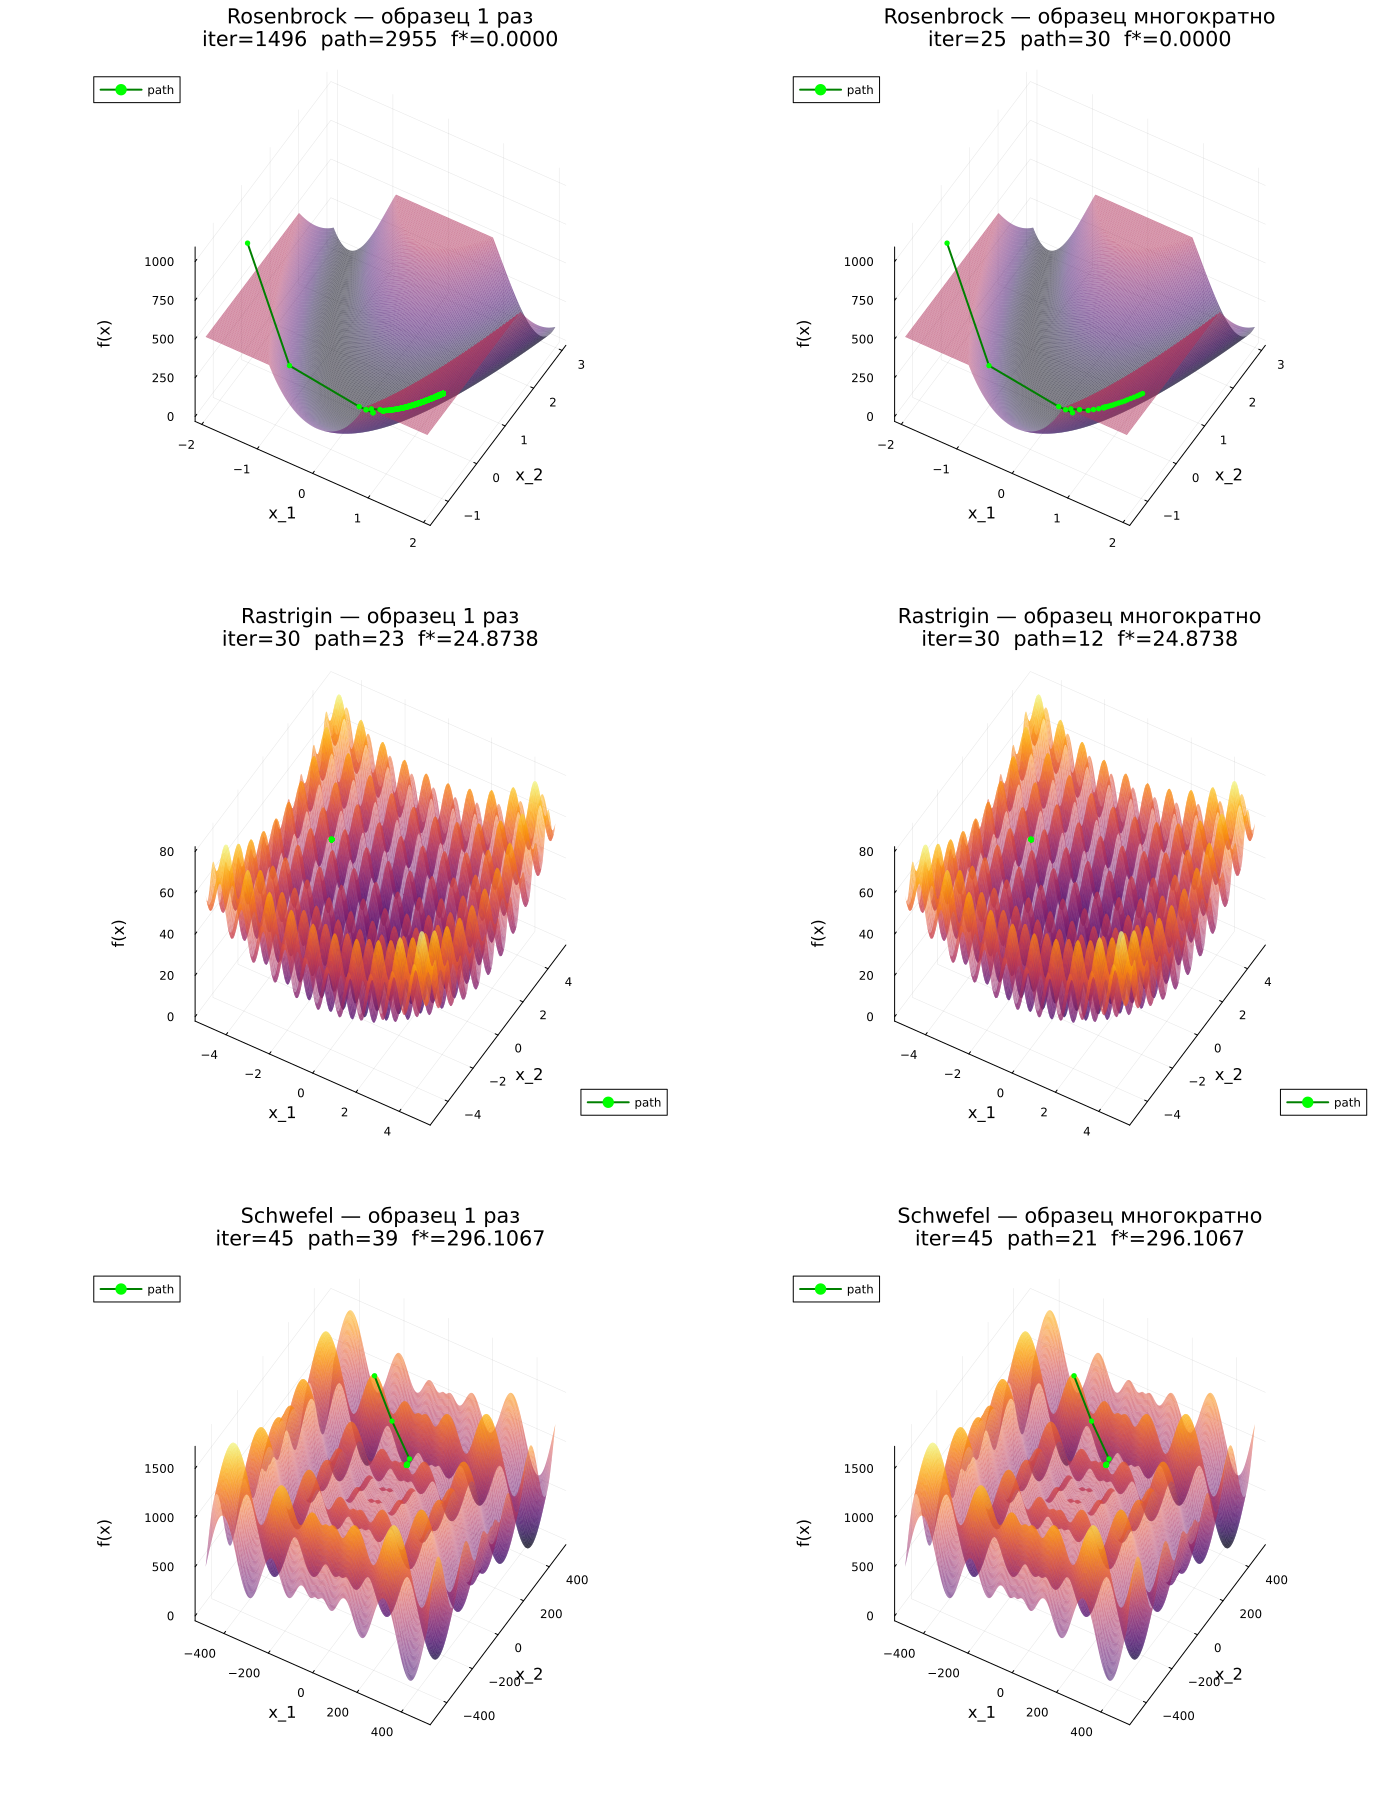

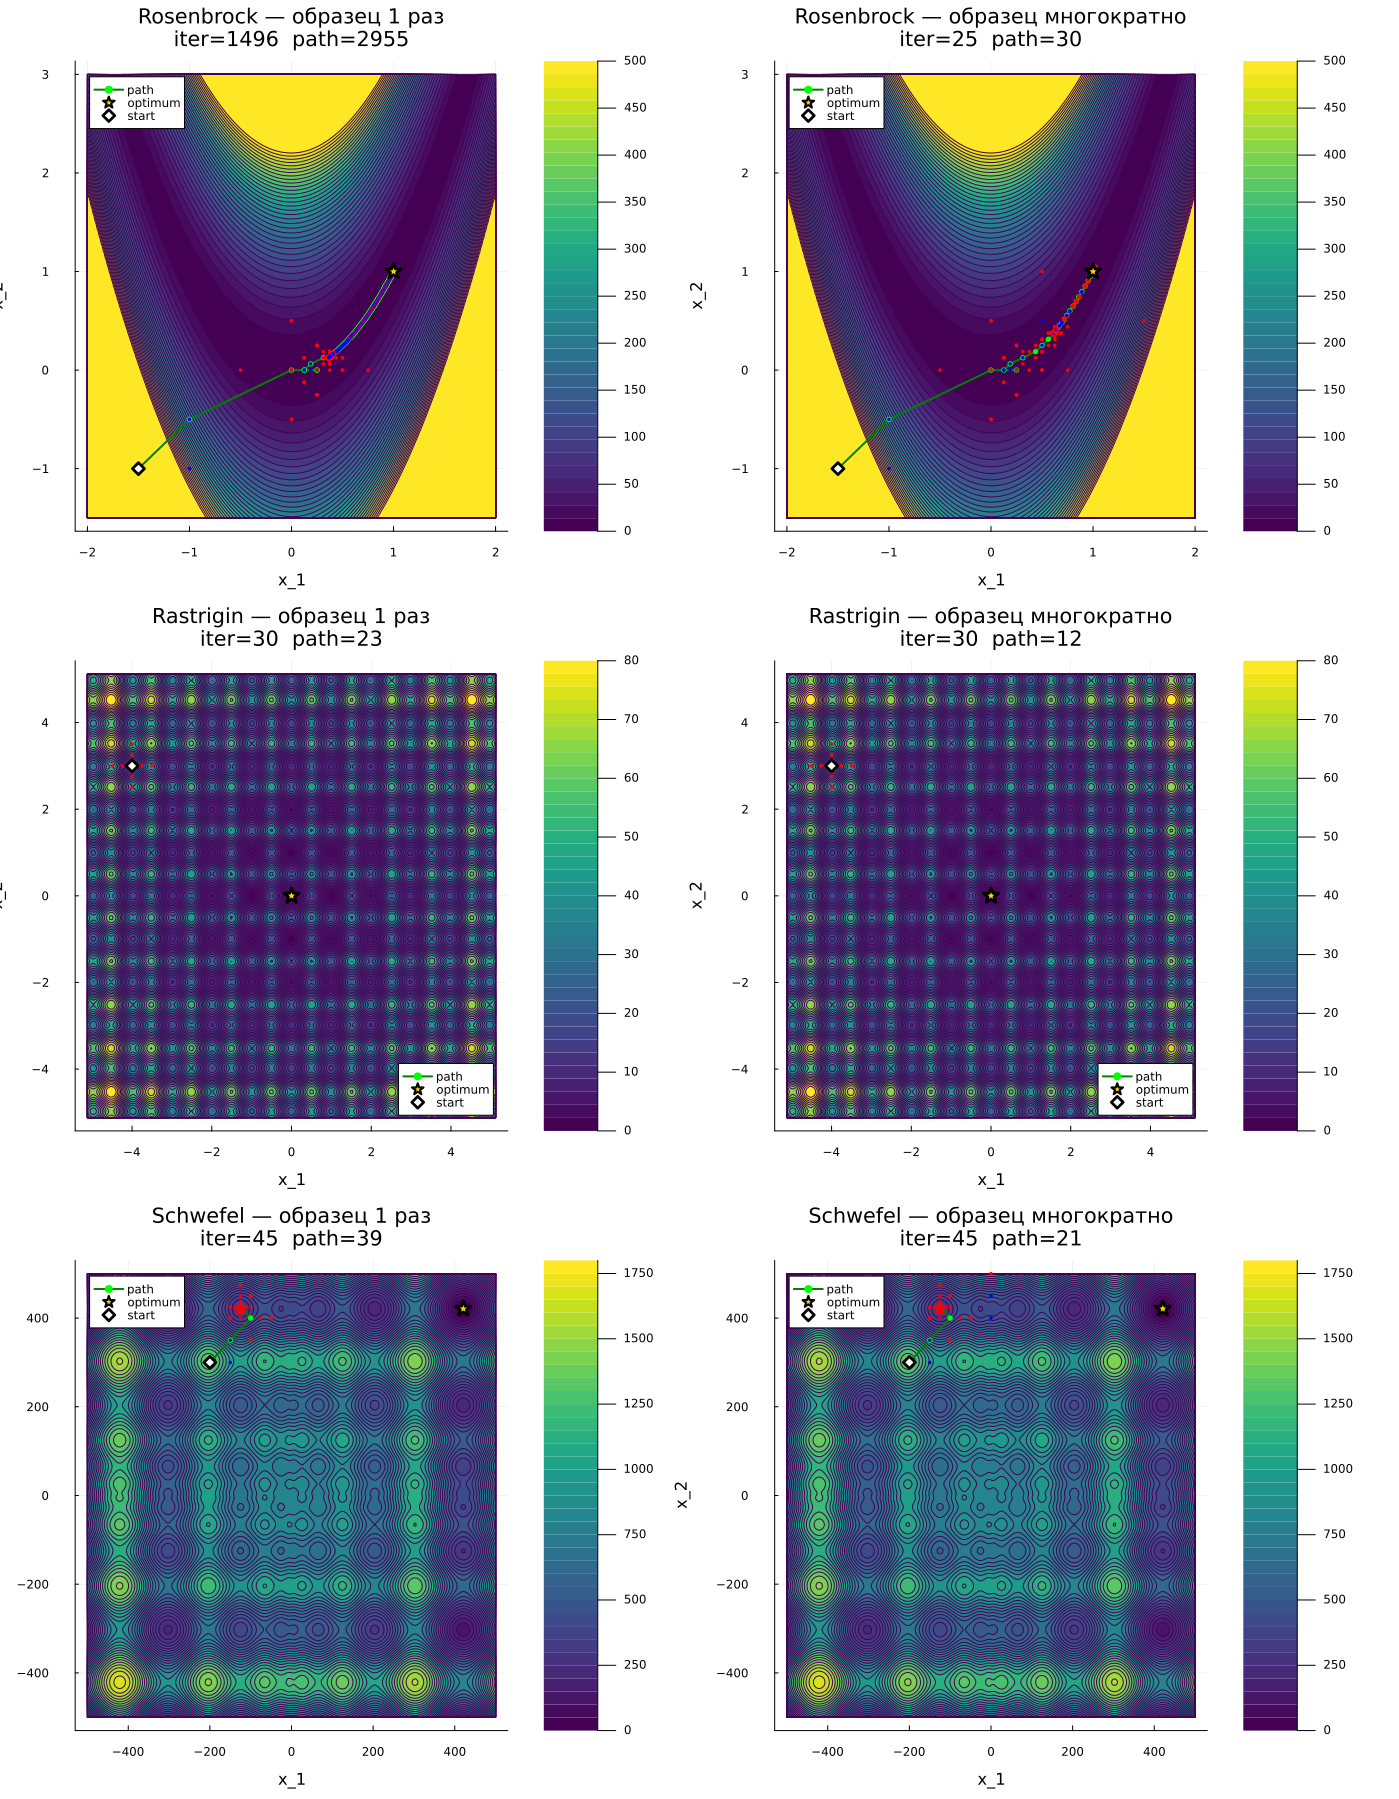